<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

<h2> 3.1 Reading data and basic stats </h2>

In [2]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

is_duplicate
0    255027
1    149263
Name: id, dtype: int64


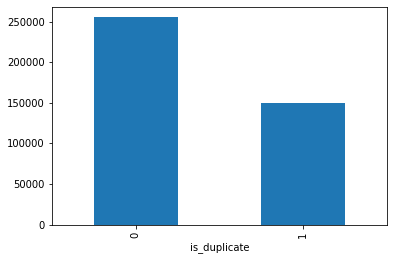

In [5]:
print(df.groupby("is_duplicate")['id'].count())
df.groupby("is_duplicate")['id'].count().plot.bar()

In [6]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [7]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [8]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())

unique_qs = len(np.unique(qids))

qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values
print(q_vals)

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157

[157 120 111 ...   1   1   1]


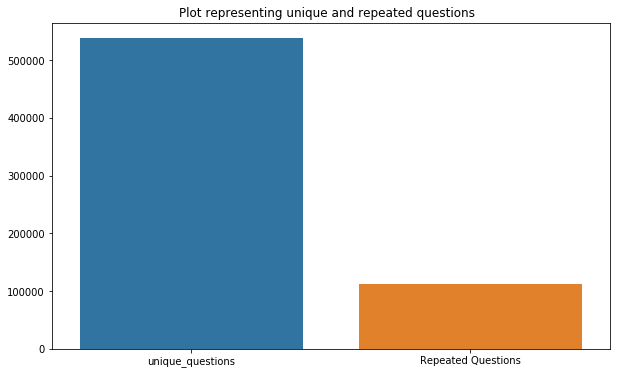

In [9]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [10]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



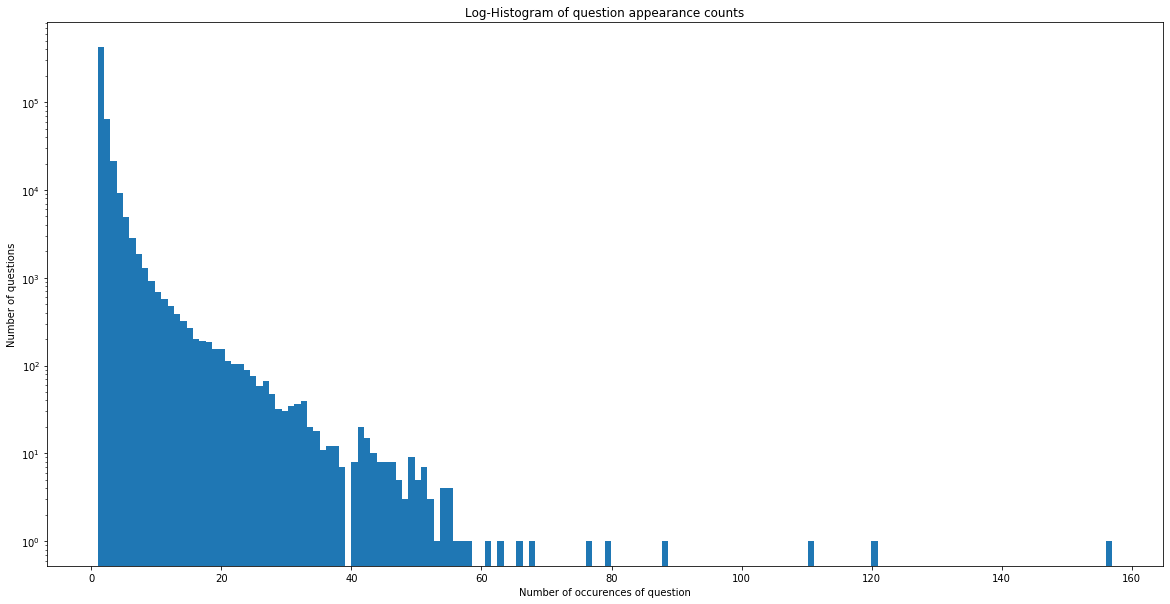

In [11]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [12]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [13]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [14]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [15]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))
print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Maximum length of the questions in question1 : " , max(df['q1_n_words']))
print ("Maximum length of the questions in question2 : " , max(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Maximum length of the questions in question1 :  125
Maximum length of the questions in question2 :  237
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> 3.3.1.1 Feature: word_share </h4>

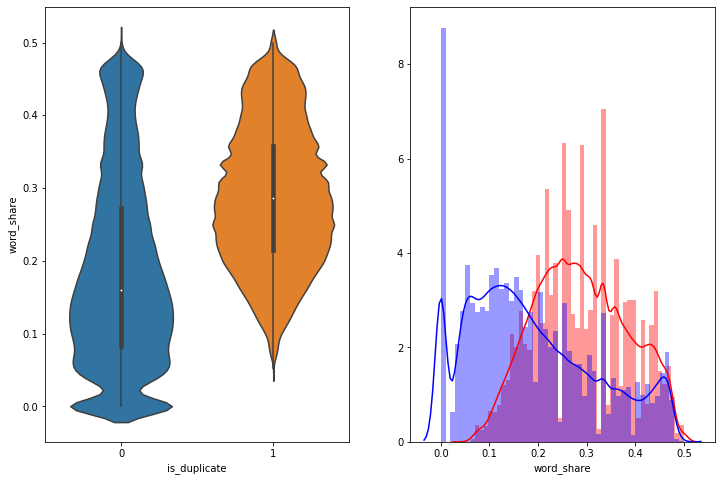

In [16]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

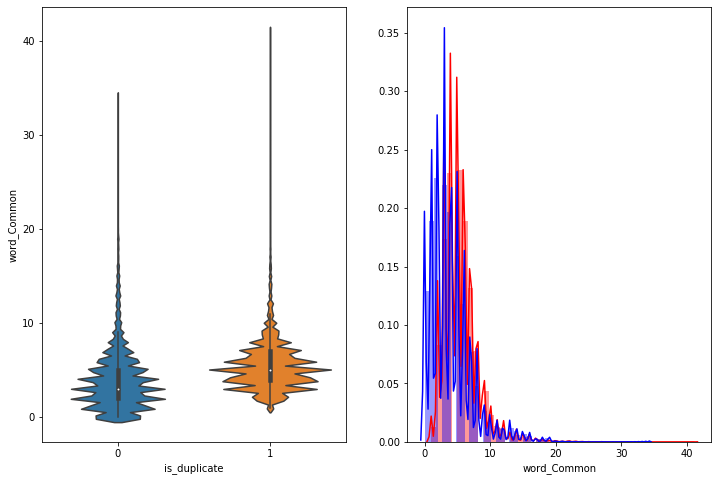

In [17]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

In [18]:
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

C:\Users\Akhil\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



In [19]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [20]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [21]:
# To get the results in 4 decemal points
import nltk
nltk.download('stopwords')

SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([1-9]+)000000", r"\1m", x)
    x = re.sub(r"([1-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Akhil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [22]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [23]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [24]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s', encoding="utf-8")
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s', encoding="utf-8")

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [25]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110303
Total number of words in non duplicate pair questions : 33194892


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


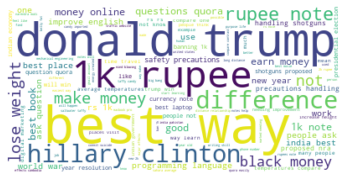

In [26]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


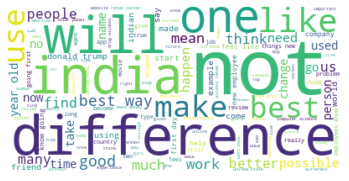

In [27]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [28]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>


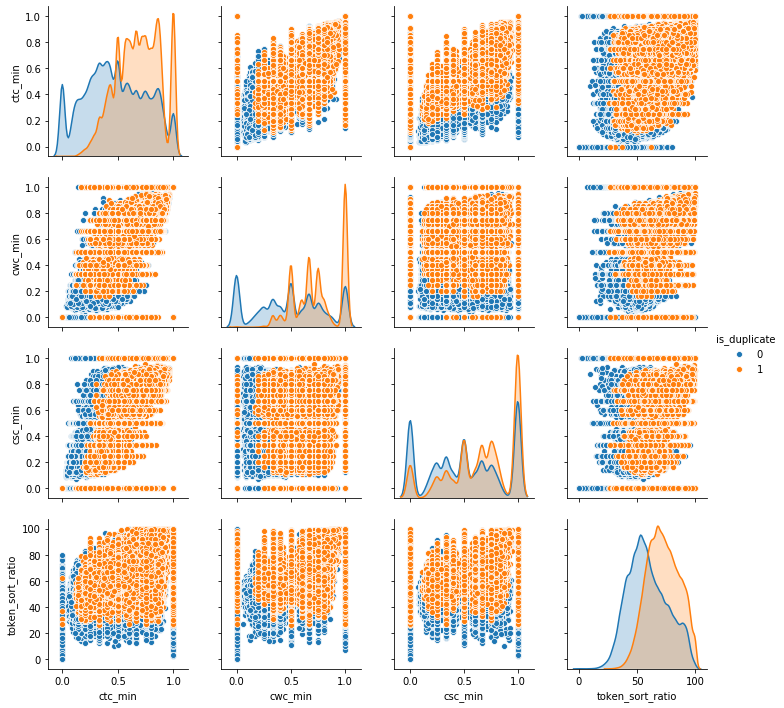

In [29]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

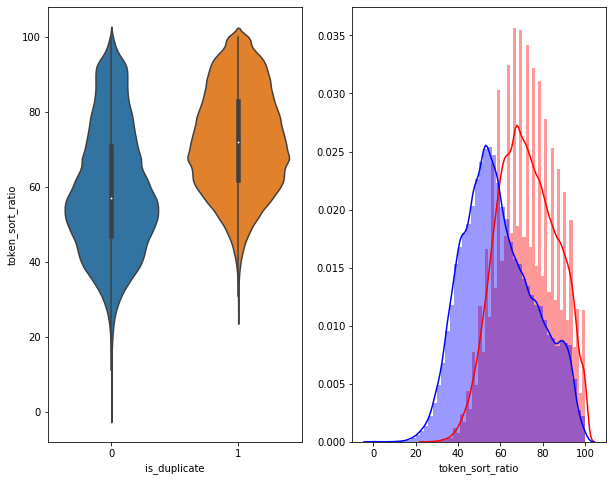

In [30]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

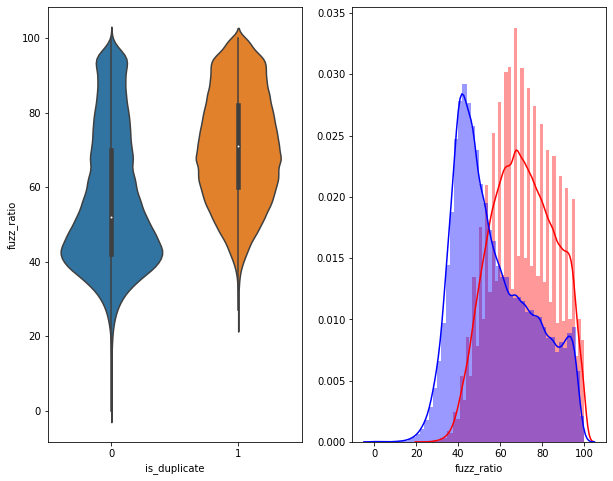

In [31]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3>3.5.2 Visualization </h3>


In [32]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [33]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...
[t-SNE] Computed neighbors for 5000 samples in 0.519s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.287s
[t-SNE] Iteration 50: error = 80.9162369, gradient norm = 0.0427600 (50 iterations in 3.218s)
[t-SNE] Iteration 100: error = 70.3915100, gradient norm = 0.0108003 (50 iterations in 2.334s)
[t-SNE] Iteration 150: error = 68.6126938, gradient norm = 0.0054721 (50 iterations in 2.337s)
[t-SNE] Iteration 200: error = 67.7680206, gradient norm = 0.0042246 (50 iterations in 2.395s)
[t-SNE] Iteration 250: error = 67.2733459, gradient norm = 0.0037275

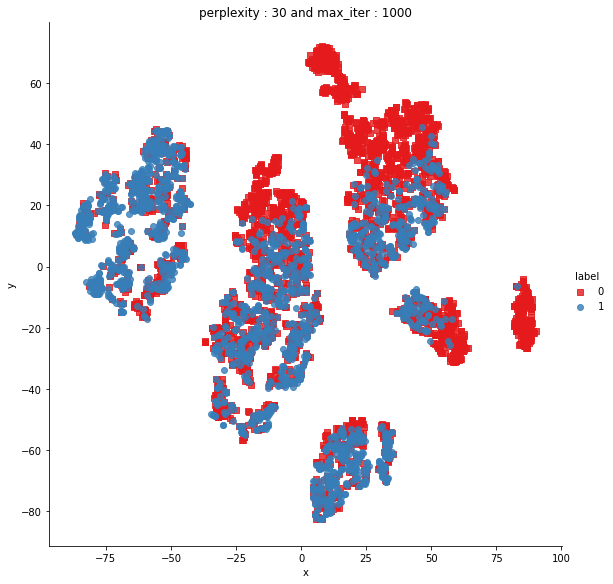

In [34]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, height=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [35]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.012s...
[t-SNE] Computed neighbors for 5000 samples in 0.561s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.310s
[t-SNE] Iteration 50: error = 80.3552017, gradient norm = 0.0329941 (50 iterations in 10.983s)
[t-SNE] Iteration 100: error = 69.1100388, gradient norm = 0.0034323 (50 iterations in 6.201s)
[t-SNE] Iteration 150: error = 67.6163483, gradient norm = 0.0017810 (50 iterations in 5.485s)
[t-SNE] Iteration 200: error = 67.0578613, gradient norm = 0.0011246 (50 iterations in 5.329s)
[t-SNE] Iteration 250: error = 66.7297821, gradient norm = 0.000927

In [36]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [37]:
df.head()

,x,y,label
0,-22.496010,-51.969185,0
1,-15.948710,-14.193419,0
2,-4.577272,14.923146,0
3,84.213593,-17.477821,0
4,-22.720020,16.079163,0


In [38]:
# Reading the file that contains advanced features
df_nlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')

In [39]:
df_nlp.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [40]:
# Reading file that contains basic features
df_common = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
df_common = df_common.fillna('')
#df_common.head()
df_common = df_common.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df_common.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [41]:
# Merging all features together into a single data frame 
df_total  = df_nlp.merge(df_common, on='id',how='left')
df_total.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [42]:
#creating a copy for safety purposes
df_total_copy = df_total.copy()

In [43]:
positive_data = df_total_copy[df_total_copy["is_duplicate"] == 1].sample(n = 50000)
negative_data = df_total_copy[df_total_copy["is_duplicate"] == 0].sample(n = 50000) 

In [44]:
final_data = pd.concat([positive_data, negative_data]) 
final_data.shape
final_data.groupby("is_duplicate")['id'].count()

is_duplicate
0    50000
1    50000
Name: id, dtype: int64

In [45]:
# Train, Cv, Test Split 

train_set1 = final_data.sample(frac=0.75, random_state=0)
test_set = final_data.drop(train_set1.index)

In [46]:
# Train, Cv, Test Split

train_set = train_set1.sample(frac=0.75, random_state=0)
cv_set = train_set1.drop(train_set.index)

## Distribution of Positive and Negative class in Train, CV and Test Data

### Train Data

is_duplicate
0    28127
1    28123
Name: id, dtype: int64


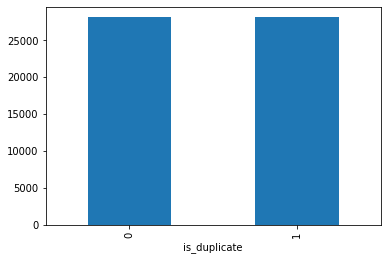

In [47]:
print(train_set.groupby("is_duplicate")['id'].count())
train_set.groupby("is_duplicate")['id'].count().plot.bar()

### CV Data

is_duplicate
0    9386
1    9364
Name: id, dtype: int64


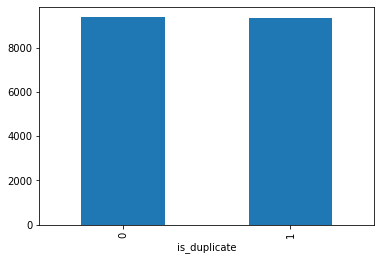

In [48]:
print(cv_set.groupby("is_duplicate")['id'].count())
cv_set.groupby("is_duplicate")['id'].count().plot.bar()

### Test Data

is_duplicate
0    12487
1    12513
Name: id, dtype: int64


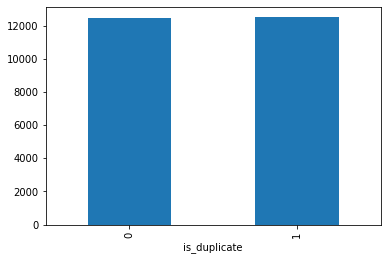

In [49]:
print(test_set.groupby("is_duplicate")['id'].count())
test_set.groupby("is_duplicate")['id'].count().plot.bar()

<h2> 3.6 Featurizing text data with tfidf vectorization </h2>

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [51]:
# Converting Question1 and Question2 to strings - from Train Data 
train_set['question1'] = train_set['question1'].apply(lambda x: str(x))
train_set['question2'] = train_set['question2'].apply(lambda x: str(x))

# Converting Question1 and Question2 to strings - from CV Data 
cv_set['question1'] = cv_set['question1'].apply(lambda x: str(x))
cv_set['question2'] = cv_set['question2'].apply(lambda x: str(x))

# Converting Question1 and Question2 to strings - from Test Data 
test_set['question1'] = test_set['question1'].apply(lambda x: str(x))
test_set['question2'] = test_set['question2'].apply(lambda x: str(x))


In [52]:
#merging Texts
train_questions = list(train_set['question1'] + train_set['question2'])

cv_questions = list(cv_set['question1'] + cv_set['question2'])
test_questions = list(test_set['question1'] + test_set['question2'])

In [53]:
#Creating TF IDF vectorizations

tf_idf_vect = TfidfVectorizer() 
tf_idf_vect.fit(train_questions) 
xTrain_tfidf=tf_idf_vect.transform(train_questions) 

xCV_tfidf=tf_idf_vect.transform(cv_questions) 
xTest_tfidf=tf_idf_vect.transform(test_questions) 

print("After transform") 
print('='*100) 
print(xTrain_tfidf.shape) 
print(xCV_tfidf.shape) 
print(xTest_tfidf.shape)

After transform
(56250, 33049)
(18750, 33049)
(25000, 33049)


In [54]:
# Creating Safe copies
train_set_copy = train_set.copy()
cv_set_copy = cv_set.copy()
test_set_copy = test_set.copy()

In [55]:
# As we taken out question1 and question2 for vectorization, so we creating a new dataframe excluding q1, q2
# DataFrame that contains Basic and Advanced features - Train Data

print("DataFrame that contains Basic and Advanced features - Train Data")

train_set = train_set.drop(['qid1','qid2','question1','question2'],axis=1)
print(train_set.shape[1])
train_set.head()


DataFrame that contains Basic and Advanced features - Train Data
28


,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
337723,337723,0,0.666644,0.399992,0.333322,0.249994,0.428565,0.299997,0.0,0.0,...,1,42,29,10,7,2.0,15.0,0.133333,2,0
281986,281986,1,0.499992,0.499992,0.749981,0.749981,0.599994,0.599994,0.0,1.0,...,6,49,57,10,10,5.0,20.0,0.250000,9,3
346050,346050,0,0.499988,0.399992,0.999900,0.249994,0.599988,0.272725,0.0,1.0,...,1,68,41,11,5,3.0,15.0,0.200000,4,2
214132,214132,1,0.999967,0.599988,0.499975,0.199996,0.799984,0.399996,1.0,0.0,...,2,22,46,5,10,4.0,15.0,0.266667,7,3
152100,152100,0,0.624992,0.454541,0.499975,0.249994,0.461535,0.428568,0.0,0.0,...,2,81,68,11,14,3.0,23.0,0.130435,3,1


In [56]:
# As we taken out question1 and question2 for vectorization, so we creating a new dataframe excluding q1, q2
# DataFrame that contains Basic and Advanced features - CV Data

print("DataFrame that contains Basic and Advanced features - CV Data")

cv_set = cv_set.drop(['qid1','qid2','question1','question2'],axis=1)
print(cv_set.shape[1])
cv_set.head()


DataFrame that contains Basic and Advanced features - CV Data
28


,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
26482,26482,0,0.999950,0.666644,0.999975,0.999975,0.999983,0.857131,0.0,1.0,...,3,31,22,7,6,5.0,13.0,0.384615,4,2
378817,378817,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,1,48,90,9,15,0.0,23.0,0.000000,2,0
338486,338486,1,0.799984,0.666656,0.666644,0.499988,0.749991,0.599994,0.0,1.0,...,1,47,59,8,10,4.0,18.0,0.222222,3,1
336505,336505,0,0.000000,0.000000,0.666644,0.499988,0.399992,0.285710,0.0,1.0,...,1,48,25,7,5,2.0,12.0,0.166667,2,0
240579,240579,0,0.499975,0.249994,0.499975,0.249994,0.499988,0.249997,0.0,1.0,...,1,45,21,8,3,1.0,11.0,0.090909,2,0


In [57]:
# As we taken out question1 and question2 for vectorization, so we creating a new dataframe excluding q1, q2
# DataFrame that contains Basic and Advanced features - Test Data

print("DataFrame that contains Basic and Advanced features - Test Data")

test_set = test_set.drop(['qid1','qid2','question1','question2'],axis=1)
print(test_set.shape[1])
test_set.head()


DataFrame that contains Basic and Advanced features - Test Data
28


,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
54871,54871,1,0.799984,0.333331,0.999967,0.299997,0.874989,0.291665,1.0,1.0,...,4,117,45,20,7,6.0,27.0,0.222222,5,3
235503,235503,1,0.999950,0.999950,0.749981,0.749981,0.833319,0.833319,1.0,1.0,...,1,28,28,6,6,5.0,12.0,0.416667,2,0
86573,86573,1,0.499992,0.499992,0.624992,0.384612,0.499997,0.363635,1.0,0.0,...,1,70,91,16,20,7.0,32.0,0.218750,4,2
254125,254125,1,0.749981,0.599988,0.000000,0.000000,0.428565,0.333330,0.0,0.0,...,5,46,44,9,7,2.0,16.0,0.125000,9,1
256327,256327,1,0.999975,0.799984,0.399992,0.399992,0.666659,0.599994,0.0,1.0,...,7,48,41,10,9,5.0,19.0,0.263158,14,0


In [58]:
# storing the class label into an ndarray
yTrain = train_set['is_duplicate'].values
yCV = cv_set['is_duplicate'].values
yTest = test_set['is_duplicate'].values

In [59]:
# dropping the is_duplicate and id columns so as the data frame remains only with basic and advanced features
train_set.drop(['id','is_duplicate'], axis=1, inplace=True)
cv_set.drop(['id','is_duplicate'], axis=1, inplace=True)
test_set.drop(['id','is_duplicate'], axis=1, inplace=True)

In [60]:
# Checking the shapes of dataframe and its corresponding question's vectorized data
# the next step after this is to stack the both
print("Train Data")
print(train_set.shape)
print(xTrain_tfidf.shape)
print("CV Data")
print(cv_set.shape)
print(xCV_tfidf.shape)
print("Test Data")
print(test_set.shape)
print(xTest_tfidf.shape)

Train Data
(56250, 26)
(56250, 33049)
CV Data
(18750, 26)
(18750, 33049)
Test Data
(25000, 26)
(25000, 33049)


In [61]:
#Stacking all features together

from scipy.sparse import hstack

train_all_features = hstack((train_set, xTrain_tfidf),format="csr",dtype='float64')
cv_all_features = hstack((cv_set, xCV_tfidf),format="csr",dtype='float64')
test_all_features = hstack((test_set, xTest_tfidf),format="csr",dtype='float64')


In [62]:
#Printing the shape of data

print("Shape of Train data "+ str(train_all_features.shape), str(yTrain.shape)) 
print("Shape of Cross Validation data "+ str(cv_all_features.shape), str(yCV.shape))
print("Shape of Test data "+ str(test_all_features.shape), str(yTest.shape)) 


Shape of Train data (56250, 33075) (56250,)
Shape of Cross Validation data (18750, 33075) (18750,)
Shape of Test data (25000, 33075) (25000,)


In [63]:
test_len = len(yTest)

<h2> Building a random model (Finding worst-case log-loss) </h2>

In [64]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.8810116097143864


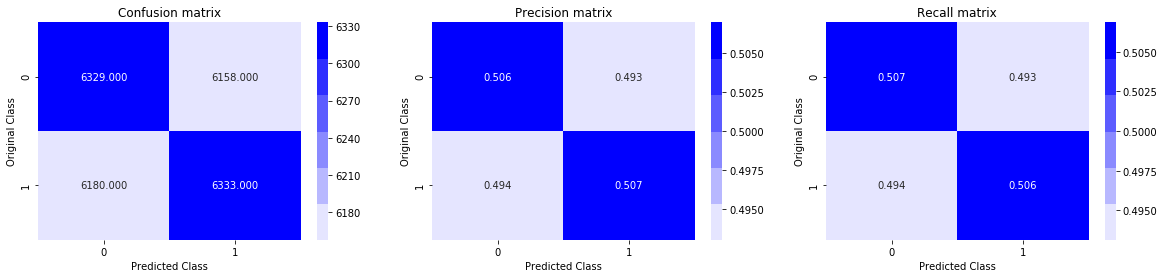

In [65]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix

predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(yTest, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(yTest, predicted_y)

## Applying Logistic Regression

#### Hyperparameter tuning for Logistic Regression

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning:

invalid value encountered in multiply

C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning:

invalid value encountered in multiply

C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning:

invalid value encountered in multiply



For values of alpha =  1e-05 CV log loss is: 0.4534056887672229


 14%|████████████                                                                        | 1/7 [00:21<02:10, 21.69s/it]C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



For values of alpha =  0.0001 CV log loss is: 0.43015095359025374


 29%|████████████████████████                                                            | 2/7 [00:45<01:51, 22.20s/it]C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



For values of alpha =  0.001 CV log loss is: 0.4427464052660173


 43%|████████████████████████████████████                                                | 3/7 [00:59<01:19, 19.98s/it]C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



For values of alpha =  0.01 CV log loss is: 0.4754572405880847


 57%|████████████████████████████████████████████████                                    | 4/7 [01:05<00:47, 15.77s/it]C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



For values of alpha =  0.1 CV log loss is: 0.4758418193701317


 71%|████████████████████████████████████████████████████████████                        | 5/7 [01:08<00:23, 11.79s/it]C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



For values of alpha =  1 CV log loss is: 0.5060357902358679


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [01:09<00:08,  8.62s/it]C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



For values of alpha =  10 CV log loss is: 0.5609831357167832


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:10<00:00,  6.31s/it]


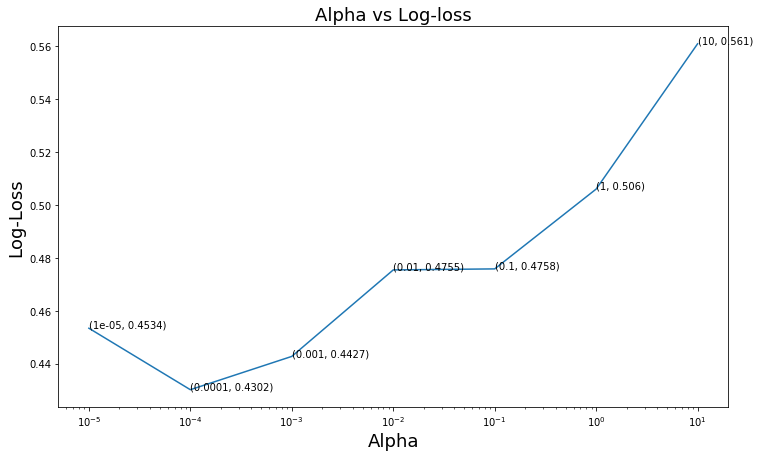

In [66]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------
from sklearn.linear_model import LogisticRegression, SGDClassifier
from tqdm import tqdm
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics.classification import accuracy_score, log_loss

cv_log_loss = []

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

for i in tqdm(alpha):
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_all_features, yTrain)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_all_features, yTrain)
    predict_y = sig_clf.predict_proba(cv_all_features)
    cv_log_loss.append(log_loss(yCV, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "CV log loss is:",log_loss(yCV, predict_y, labels=clf.classes_, eps=1e-15))

    
plt.figure(figsize = (12, 7))
plt.xscale('log')
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)

plt.title("Alpha vs Log-loss", fontsize = 18)
plt.xlabel("Alpha", fontsize = 18)
plt.ylabel("Log-Loss", fontsize = 18)
plt.show()
    


#### Logistic Regression with best Hyperparameter

C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Best alpha value = 0.0001, Test LogLoss = 0.43441720082088225, Test Accuracy Score = 78.16%


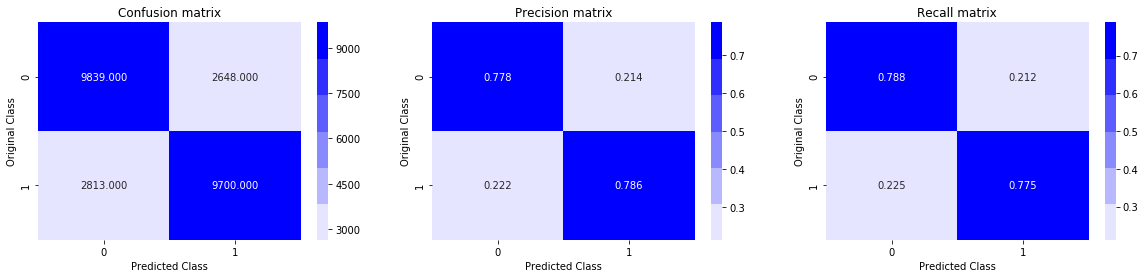

In [67]:
# Building SVM on optimal alpha value
values_log_loss = []
accuracy_score_values = []

best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(loss = "log", alpha = best_alpha, penalty='l2', random_state=42)
clf.fit(train_all_features, yTrain)
sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
sig_clf.fit(train_all_features, yTrain)

predict_y = sig_clf.predict_proba(test_all_features)
LR_LogLoss = log_loss(yTest, predict_y)
LR_Accuracy = accuracy_score(yTest, sig_clf.predict(test_all_features))
print('Best alpha value = {}, Test LogLoss = {}, Test Accuracy Score = {}%'.format(best_alpha, LR_LogLoss, round((float(LR_Accuracy))*100,2)))
plot_confusion_matrix(yTest, sig_clf.predict(test_all_features))

values_log_loss.append(LR_LogLoss)
accuracy_score_values.append(LR_Accuracy)



### Observations:

**Metrics**
- Test log loss - 0.434
- Accuracy - 78.16%

**Confusion Matrix**
- Out of 12487 Negative points, XGBoost correctly classified 9839 points as Negative.
- Out of 12513 Positive points, XGBoost correctly classified 9700 points as Positive.
<br>

**Precision Matrix**
- Of All the points that model predicted to be Negative 77.8% points are actually Negative.
- Of All the points that model predicted to be Positive 78.6% points are actually Positive.
<br>

**Recall Matrix**
- Of All the points that actually belong to Negative class 78.8% points are correctly classified.
- Of All the points that actually belong to Positive class 77.5% points are correctly classified.

## Applying Linear SVM

#### Hyperparameter tuning for Linear SVM

In [68]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------
from sklearn.linear_model import LogisticRegression, SGDClassifier
from tqdm import tqdm
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics.classification import accuracy_score, log_loss

cv_log_loss_svm = []

alpha = [10 ** x for x in range(-6, 1)] # hyperparam for SGD classifier.

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(train_all_features, yTrain)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_all_features, yTrain)
    predict_y = sig_clf.predict_proba(cv_all_features)
    cv_log_loss_svm.append(log_loss(yCV, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "CV log loss is:",log_loss(yCV, predict_y, labels=clf.classes_, eps=1e-15))

    

    


C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning:

invalid value encountered in multiply

C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning:

invalid value encountered in multiply

C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning:

invalid value encountered in multiply



For values of alpha =  1e-06 CV log loss is: 0.4334481158273622


C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning:

invalid value encountered in multiply

C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning:

invalid value encountered in multiply

C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning:

invalid value encountered in multiply



For values of alpha =  1e-05 CV log loss is: 0.4425039582377444


C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



For values of alpha =  0.0001 CV log loss is: 0.47163247769391387


C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



For values of alpha =  0.001 CV log loss is: 0.5010517586347397


C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning:

invalid value encountered in multiply



For values of alpha =  0.01 CV log loss is: 0.5113326728528782


C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



For values of alpha =  0.1 CV log loss is: 0.49582324153561574


C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



For values of alpha =  1 CV log loss is: 0.5870291883932246


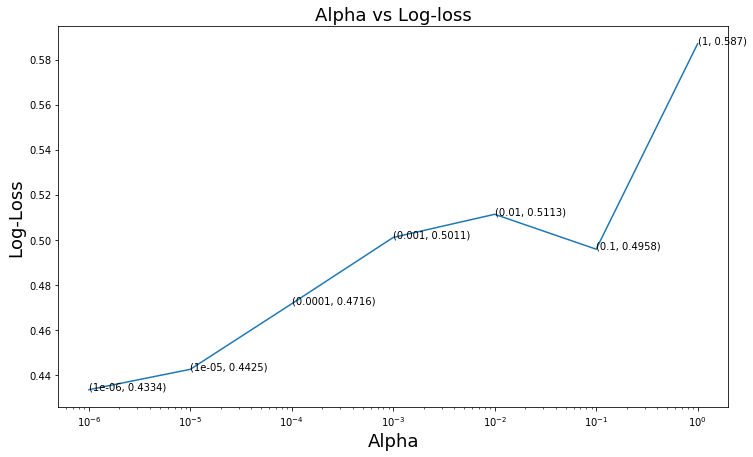

In [69]:
plt.figure(figsize = (12, 7))
plt.xscale('log')
plt.plot(alpha, cv_log_loss_svm)
for j in zip(alpha, np.round(cv_log_loss_svm, 4)):
    plt.annotate(j, j)

plt.title("Alpha vs Log-loss", fontsize = 18)
plt.xlabel("Alpha", fontsize = 18)
plt.ylabel("Log-Loss", fontsize = 18)
plt.show()

#### SVM with best Hyperparameter

C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning:

invalid value encountered in multiply

C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning:

invalid value encountered in multiply

C:\Users\Akhil\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning:

invalid value encountered in multiply



Best alpha value = 1e-06, Test LogLoss = 0.4370847155187342, Test Accuracy Score = 78.26%


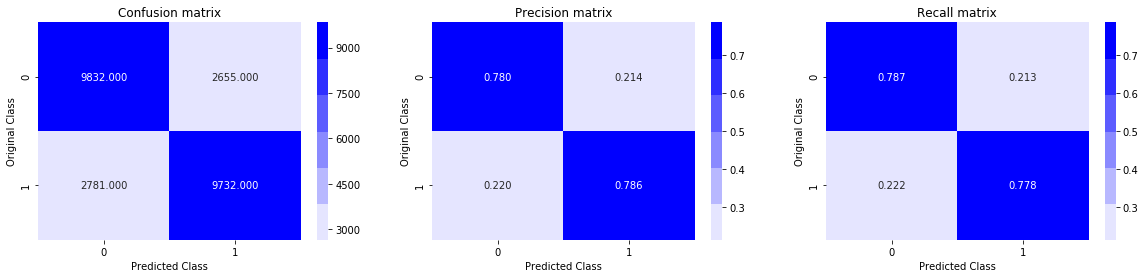

In [70]:
# Building SVM on optimal alpha value

values_log_loss1 = []
accuracy_score_values1 = []

best_alpha = alpha[np.argmin(cv_log_loss_svm)]
clf = SGDClassifier(alpha=best_alpha, penalty='l1', loss='hinge', random_state=42)
clf.fit(train_all_features, yTrain)
sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
sig_clf.fit(train_all_features, yTrain)

predict_y = sig_clf.predict_proba(test_all_features)
SVM_LogLoss = log_loss(yTest, predict_y)
SVM_Accuracy = accuracy_score(yTest, sig_clf.predict(test_all_features))
print('Best alpha value = {}, Test LogLoss = {}, Test Accuracy Score = {}%'.format(best_alpha, SVM_LogLoss, round((float(SVM_Accuracy))*100,2)))
plot_confusion_matrix(yTest, sig_clf.predict(test_all_features))

values_log_loss1.append(SVM_LogLoss)
accuracy_score_values1.append(SVM_Accuracy)



### Observations:

**Metrics**
- Test log loss - 0.437
- Accuracy - 78.2%

**Confusion Matrix**
- Out of 12487 Negative points, SVM correctly classified 9832 points as Negative.
- Out of 12513 Positive points, SVM correctly classified 9732 points as Positive.
<br>

**Precision Matrix**
- Of All the points that model predicted to be Negative 78% points are actually Negative.
- Of All the points that model predicted to be Positive 78.6% points are actually Positive.
<br>

**Recall Matrix**
- Of All the points that actually belong to Negative class 78.7% points are correctly classified.
- Of All the points that actually belong to Positive class 77.8% points are correctly classified.

## XGBoost on TFIDF weighted word-vectors

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [72]:
#train_set_copy 
ques_train = list(train_set_copy['question1']) + list(train_set_copy['question2'])
ques_cv = list(cv_set_copy['question1']) + list(cv_set_copy['question2'])
ques_test = list(test_set_copy['question1']) + list(test_set_copy['question2'])


In [74]:
#TFIDF vectorizations
tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(ques_train)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [75]:
#---------------------TRAIN DATA - QUESTION 1 ----------------------

# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(train_set_copy['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
train_set_copy['q1_feats_m'] = list(vecs1)


100%|████████████████████████████████████████████████████████████████████████████| 56250/56250 [10:57<00:00, 85.52it/s]


In [76]:
#--------------------- TRAIN DATA - QUESTION 2 ----------------------

vecs2 = []
for qu2 in tqdm(list(train_set_copy['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
train_set_copy['q2_feats_m'] = list(vecs2)

100%|████████████████████████████████████████████████████████████████████████████| 56250/56250 [11:03<00:00, 82.34it/s]


In [83]:
# Dropping q1 and q2

df3 = train_set_copy.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [84]:
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
337723,-35.103368,-42.076737,-106.139874,50.545081,33.351267,158.289629,34.485578,70.027434,135.044529,113.465422,...,2.747804,-45.782894,1.336823,-50.936050,-104.294023,-54.558876,-23.082207,118.962447,-38.577026,119.406041
281986,-15.052867,-73.770409,14.945232,28.930698,47.743161,17.244942,-21.166520,43.696552,83.900574,51.730056,...,28.794167,4.839643,-61.310774,47.334708,-17.481381,-5.768808,-35.052739,52.409003,46.260487,26.418571
346050,81.018205,-12.210525,-41.729436,28.797472,8.109428,87.001662,-9.811281,1.468339,116.425878,127.144322,...,-46.638723,-22.862380,-25.216155,15.708772,-37.831981,46.977412,74.223302,194.425685,65.633978,10.742973
214132,10.998164,-35.027086,-37.137201,-25.079446,29.005478,53.305014,43.867692,17.819242,64.870846,56.416896,...,33.257626,-44.206194,-4.469919,-41.904230,-46.330166,18.273536,-61.275726,23.619588,9.440128,-8.174985
152100,26.693535,-49.616067,-66.917897,65.300167,89.685575,59.297417,28.646339,15.691378,145.660976,195.725030,...,2.602584,-108.314472,-65.735593,54.935979,10.123165,23.949040,-120.054238,184.521327,74.171505,-34.157821


In [85]:
df3_q1['id']=train_set_copy['id']
df3_q2['id']=train_set_copy['id']

In [86]:
df3  = df3.merge(df3_q1, on='id',how='left')
df3  = df3.merge(df3_q2, on='id',how='left')


In [92]:
df3=df3.drop(['q1_feats_m','q2_feats_m'],axis=1)
df3.head()

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,337723,0.666644,0.399992,0.333322,0.249994,0.428565,0.299997,0.0,0.0,3.0,...,17.295386,-18.235175,-23.838584,19.794789,-24.709846,-2.289971,-33.191900,5.109270,-57.157182,21.770991
1,281986,0.499992,0.499992,0.749981,0.749981,0.599994,0.599994,0.0,1.0,0.0,...,17.077608,-34.329219,-61.716570,69.105667,25.743497,32.875573,46.258113,75.747111,9.062300,45.971803
2,346050,0.499988,0.399992,0.999900,0.249994,0.599988,0.272725,0.0,1.0,6.0,...,23.296126,-48.189643,-40.312882,-21.796483,-19.182546,-1.441931,41.653231,81.704234,-8.802265,58.505405
3,214132,0.999967,0.599988,0.499975,0.199996,0.799984,0.399996,1.0,0.0,5.0,...,43.181050,-30.717877,-60.427118,-25.870759,3.821274,19.514249,-59.859217,93.775359,-5.690884,28.280994
4,152100,0.624992,0.454541,0.499975,0.249994,0.461535,0.428568,0.0,0.0,1.0,...,-17.634290,39.611974,-31.981254,46.224008,21.878324,-60.740909,-59.763465,71.827406,65.989930,72.671379


In [96]:
del df3_q1
del df3_q2

In [94]:
#---------------------CV DATA - QUESTION 1 ----------------------

# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(cv_set_copy['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
cv_set_copy['q1_feats_m'] = list(vecs1)


100%|████████████████████████████████████████████████████████████████████████████| 18750/18750 [04:59<00:00, 27.60it/s]


In [95]:
#---------------------CV DATA - QUESTION 2 ----------------------

vecs2 = []
for qu2 in tqdm(list(cv_set_copy['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
cv_set_copy['q2_feats_m'] = list(vecs2)

100%|████████████████████████████████████████████████████████████████████████████| 18750/18750 [12:10<00:00, 25.66it/s]


In [97]:
# Dropping q1 and q2

df4 = cv_set_copy.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df4_q1 = pd.DataFrame(df4.q1_feats_m.values.tolist(), index= df4.index)
df4_q2 = pd.DataFrame(df4.q2_feats_m.values.tolist(), index= df4.index)

In [99]:
df4_q1['id']=cv_set_copy['id']
df4_q2['id']=cv_set_copy['id']

In [100]:
df4  = df4.merge(df4_q1, on='id',how='left')
df4  = df4.merge(df4_q2, on='id',how='left')


In [101]:
df4=df4.drop(['q1_feats_m','q2_feats_m'],axis=1)
df4.head()

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,26482,0.999950,0.666644,0.999975,0.999975,0.999983,0.857131,0.0,1.0,1.0,...,10.335171,14.698022,-8.569448,47.706964,1.741593,7.468497,-41.902209,16.733559,-40.415771,-8.080527
1,378817,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,6.0,...,-1.976317,-47.644356,-38.367095,110.571229,49.224757,35.967433,12.223026,188.907811,84.354995,25.690439
2,338486,0.799984,0.666656,0.666644,0.499988,0.749991,0.599994,0.0,1.0,2.0,...,-24.336272,-86.913056,-5.762937,20.217451,-17.803451,-23.029335,8.590406,106.604035,10.603118,14.997144
3,336505,0.000000,0.000000,0.666644,0.499988,0.399992,0.285710,0.0,1.0,2.0,...,0.104685,-7.387905,-36.552945,13.804303,-27.531549,8.366655,40.307212,91.906734,-5.386399,26.899832
4,240579,0.499975,0.249994,0.499975,0.249994,0.499988,0.249997,0.0,1.0,4.0,...,15.742851,-7.640597,3.311832,36.443202,-34.810915,-59.957125,39.850483,40.245324,4.008359,0.677561


In [104]:
#---------------------TEST DATA - QUESTION 1 ----------------------

# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(test_set_copy['question1'])):
    doc1 = nlp(qu1) 

    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
test_set_copy['q1_feats_m'] = list(vecs1)


100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [15:51<00:00, 26.26it/s]


In [105]:

#---------------------TEST DATA - QUESTION 2 ----------------------

vecs2 = []
for qu2 in tqdm(list(test_set_copy['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
test_set_copy['q2_feats_m'] = list(vecs2)

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [14:04<00:00, 29.62it/s]


In [106]:
# Dropping q1 and q2

df5 = test_set_copy.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df5_q1 = pd.DataFrame(df5.q1_feats_m.values.tolist(), index= df5.index)
df5_q2 = pd.DataFrame(df5.q2_feats_m.values.tolist(), index= df5.index)

In [107]:
df5_q1['id']=test_set_copy['id']
df5_q2['id']=test_set_copy['id']

In [108]:
df5  = df5.merge(df5_q1, on='id',how='left')
df5  = df5.merge(df5_q2, on='id',how='left')


In [109]:
df5=df5.drop(['q1_feats_m','q2_feats_m'],axis=1)
df5.head()

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,54871,0.799984,0.333331,0.999967,0.299997,0.874989,0.291665,1.0,1.0,16.0,...,-13.744836,-12.195311,-35.032580,97.228733,-38.999556,-38.723055,16.970554,15.446047,56.747869,12.240173
1,235503,0.999950,0.999950,0.749981,0.749981,0.833319,0.833319,1.0,1.0,0.0,...,-10.891021,12.055391,-10.893322,-16.134326,35.601955,-4.515517,-35.865489,13.588039,-15.189365,17.089109
2,86573,0.499992,0.499992,0.624992,0.384612,0.499997,0.363635,1.0,0.0,6.0,...,119.547058,52.718913,-9.964197,50.149665,-76.830914,-53.853350,-133.970141,72.090593,-70.355136,52.994602
3,254125,0.749981,0.599988,0.000000,0.000000,0.428565,0.333330,0.0,0.0,2.0,...,25.601107,-18.190452,-7.403553,48.380954,0.424721,-2.861600,21.862107,14.862784,-39.180916,22.214277
4,256327,0.999975,0.799984,0.399992,0.399992,0.666659,0.599994,0.0,1.0,1.0,...,-15.560243,32.578911,12.848844,10.557820,-42.391124,-7.471391,11.865136,7.527708,74.403563,-7.032863


In [110]:
del df5_q2
del df5_q1

In [111]:
df3=df3.drop(['id'],axis=1)
df4=df4.drop(['id'],axis=1)
df5=df5.drop(['id'],axis=1)

In [113]:
XTrain = df3.to_numpy()
XCV = df4.to_numpy()
XTest = df5.to_numpy()

In [114]:
#Shape of Training data


print("Shape of Train data "+ str(XTrain.shape), str(yTrain.shape)) 
print("Shape of Cross Validation data "+ str(XCV.shape), str(yCV.shape))
print("Shape of Test data "+ str(XTest.shape), str(yTest.shape)) 


Shape of Train data (56250, 218) (56250,)
Shape of Cross Validation data (18750, 218) (18750,)
Shape of Test data (25000, 218) (25000,)


## XGBoost

In [117]:
from xgboost import XGBClassifier

depth = [2, 3, 4, 6, 8] 
estimators = [100, 200, 300, 400, 500]  
cv_log_loss = []

# XGBoost 
for i in tqdm(depth):    
    for j in estimators:        
        clf0 = XGBClassifier(max_depth=i, n_estimators=j, scale_pos_weight=1, objective ='binary:logistic')        
        clf0.fit(XTrain, yTrain)
        predict_y = clf0.predict_proba(XCV)
        cv_log_loss.append(log_loss(yCV, predict_y))
        print("depth "+str(i)+" estimators "+str(j)+" CV log loss = "+str(log_loss(yCV, predict_y)))
        


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

depth 2 estimators 100 CV log loss = 0.39413046615027514
depth 2 estimators 200 CV log loss = 0.3732214810730998
depth 2 estimators 300 CV log loss = 0.36418931564261847
depth 2 estimators 400 CV log loss = 0.3598013645501278
depth 2 estimators 500 CV log loss = 0.35682741156494635



 20%|████████████████                                                                | 1/5 [24:11<1:36:45, 1451.43s/it]

depth 3 estimators 100 CV log loss = 0.3729435751570699
depth 3 estimators 200 CV log loss = 0.3585666779548093
depth 3 estimators 300 CV log loss = 0.35329479400826674
depth 3 estimators 400 CV log loss = 0.35000416240541
depth 3 estimators 500 CV log loss = 0.34842109800427373



 40%|███████████████████████████████▏                                              | 2/5 [1:05:09<1:27:39, 1753.31s/it]

depth 4 estimators 100 CV log loss = 0.360911192642157
depth 4 estimators 200 CV log loss = 0.35148079771690516
depth 4 estimators 300 CV log loss = 0.34769756517760775
depth 4 estimators 400 CV log loss = 0.3458982935323394
depth 4 estimators 500 CV log loss = 0.3450598196003172



 60%|██████████████████████████████████████████████▊                               | 3/5 [1:50:58<1:08:24, 2052.25s/it]

depth 6 estimators 100 CV log loss = 0.3491953383262432
depth 6 estimators 200 CV log loss = 0.34350036484280716
depth 6 estimators 300 CV log loss = 0.3414102082034969
depth 6 estimators 400 CV log loss = 0.34060411963467435
depth 6 estimators 500 CV log loss = 0.3408959074503551



 80%|████████████████████████████████████████████████████████████████                | 4/5 [2:52:27<42:23, 2543.27s/it]

depth 8 estimators 100 CV log loss = 0.3434921169824526
depth 8 estimators 200 CV log loss = 0.340583522789053
depth 8 estimators 300 CV log loss = 0.3448427052816672
depth 8 estimators 400 CV log loss = 0.34896466130747744
depth 8 estimators 500 CV log loss = 0.3560017249156426



100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [4:16:12<00:00, 3287.64s/it]

In [120]:
# Building XGBoost on optimal depth and optimal estimators
optimal = XGBClassifier(max_depth=6, n_estimators=400, scale_pos_weight=1, objective='binary:logistic')
optimal.fit(XTrain, yTrain)
predict_final = optimal.predict_proba(XTest)
predict_bin = optimal.predict(XTest)
xgb_log_loss = log_loss(yTest, predict_final)
xgb_Accuracy = accuracy_score(yTest, predict_bin)

print("Optimal Depth = 6 & Optimal estimators =400")
print("Test Log loss")
print(xgb_log_loss)
print("Accuracy")
print(xgb_Accuracy)

Optimal Depth = 6 & Optimal estimators =400
Test Log loss
0.34652445800026516
Test Log loss
0.82864


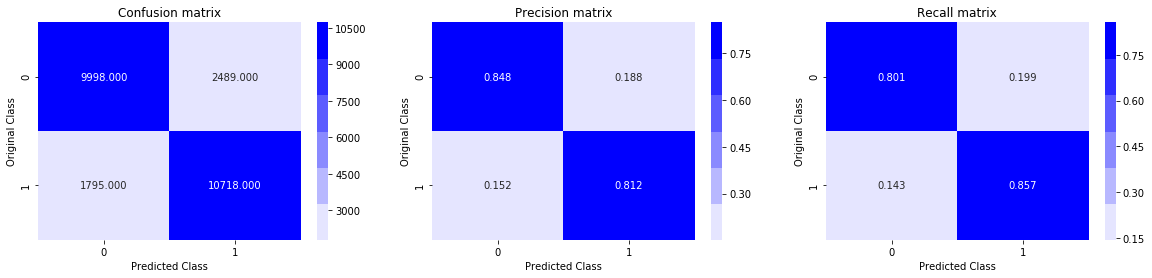

In [121]:
plot_confusion_matrix(yTest, predict_bin)

### Observations:

**Metrics**
- Test log loss - 0.346
- Accuracy - 82.8%

**Confusion Matrix**
- Out of 12487 Negative points, XGBoost correctly classified 9998 points as Negative.
- Out of 12513 Positive points, XGBoost correctly classified 10718 points as Positive.
<br>

**Precision Matrix**
- Of All the points that model predicted to be Negative 84.8% points are actually Negative.
- Of All the points that model predicted to be Positive 81.2% points are actually Positive.
<br>

**Recall Matrix**
- Of All the points that actually belong to Negative class 80.1% points are correctly classified.
- Of All the points that actually belong to Positive class 85.7% points are correctly classified.

## Conclusion

In [122]:
from prettytable import PrettyTable    
x = PrettyTable()
x.title = " Comparision of Models "

x.field_names = ["Vectorizer", "Model Name", "Accuracy", "Log Loss"]
x.add_row(["-", "Random Model", "-", 0.88])
x.add_row(["TF-IDF", "Logistic Regression", 78.16, 0.434])
x.add_row(["TF-IDF", "Linear SVM", 78.26, 0.437])
x.add_row(["TF-IDF weighted W2V", "XGBoost", 82.8, 0.346])
print(x)

+---------------------+---------------------+----------+----------+
|      Vectorizer     |      Model Name     | Accuracy | Log Loss |
+---------------------+---------------------+----------+----------+
|          -          |     Random Model    |    -     |   0.88   |
|        TF-IDF       | Logistic Regression |  78.16   |  0.434   |
|        TF-IDF       |      Linear SVM     |  78.26   |  0.437   |
| TF-IDF weighted W2V |       XGBoost       |   82.8   |  0.346   |
+---------------------+---------------------+----------+----------+


### Key Observations and Steps of the Model Implementation

#### Preprocessing
1. Removing html tags, Punctuations, stemming, stopwords
2. Expanding contractions
<br>

#### Feature Extraction
1. Basic Feature Extraction (word count, question length, frequency of question, word common, word share)
2. Advanced Feature Extraction (NLP and Fuzzy Features) 
<br>

#### Model Implementaion
1. First we implemented a Random Model that gave a log loss of 0.88 (Worst Case Scenario). So, the models we implement now should have a log loss less than this model.
2. We applied Logistic Regression on 100K data points that are TFIDF vectorized and hyperparameter tuning was done. This model produced a log loss of 0.434
3. Next, We applied Linear SVM on 100K data points that are TFIDF vectorized and hyperparameter tuning was done. This model produced a log loss of 0.437.
4. Later, We applied XGBoost on 100K data points that are TFIDF weighted Word2Vec and hyperparameter tuning was done. This model produced a log loss of 0.346.

Finally, we can conclude that on large dimensional data, models like Logistic Regression, Linear SVM gives better results as the decision surface does better in seperating positive and negative points.
And, on low to mid dimensional data, Boosting algorithms like XGBoost will perform very well.
